# Homeostasis Rule

Different homeostasis regulation rules are tryed in an empirical way. 

The value "hom_power" represents the number of events where matching result for the closest kernel is different before and after applying homeostasis gain. This measurement is normalized by the total number of events. 

For the classification results, one can notice two different results with homrun=False and homrun=True. It means classification is performed both using the homeostasis rule and without the homeostasis rule. For training clusters, homoestatis is always active.

Results:

- One can see that performances are better when homrun = True. It means that if homeostasis is active only for training the cluster and not for classification we get better results. Forcing histograms to be equal can be beneficial for learning kernels but it can distort classification. 
- For gain formlulas number 1.b, 2.a, 3, 4, 6.c, 7.a, 7.b and 7.c gives interesting patterns for the learned kernels. Center-surround type patterns appears for the first layer and the second one (sometimes) and Gabor-like kernels are learned for the second layer. 
- Results for classification are still not that good but some of them outperform the results without homeostasis. N-MNIST can be challenging to classify with this type of network (too many layers? classification with histograms is too week?). Tau was 'optimized' but some hyperparameters or the architeture of the network can be changed. Some logistic regression could be applied instead of histogram distances for classification. 

In [1]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%cd '../'
#import sys
#sys.path.append('..')

/Users/lolo/quantic/science/HomeHots/HOTS_clone_laurent


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time

from HOTS.ToolsMonitor import GenerateActivationMap, DisplayActivationMap
from HOTS.Event import Event, SimpleAlphabet, LoadNMNIST
from HOTS.STS import STS
from HOTS.Layer import ClusteringLayer
from HOTS.ToolsMonitor import (
    DisplayImage,
    DisplaySurface3D,
    DisplaySurface2D,
    DisplayConvergence,
)
from HOTS.Tools import SaveObject, LoadObject
from HOTS.Classifier import Classifier
from HOTS.Network import Network
from HOTS.KmeansLagorce import KmeansLagorce
from HOTS.KmeansMaro import KmeansMaro
from HOTS.Event import conv2eve

tau = 9e-4 # -> tau=1ms, si on prend 10 ms on est à 1s pour la dernière couche et les vidéos font 0.3s en moyenne
R = 2
filthr = 2
nbkNN = 3
algo = 'lagorce'
decay = 'exponential'
hom = True
krnlinit='rdn'
nb_cluster = [4, 8, 16]
ImageSize = (34, 34)
DataPath = 'Data/testsetnmnist.p'

NbClusteringData = 15
NbTrainingData = 40
NbTestingData = 40
_1ofich = False

event_tr, event_te, event_cl, label_tr, label_te = LoadNMNIST(
NbTrainingData, NbTestingData, NbClusteringData, OneOfEach=_1ofich, Path=DataPath, OutOnePolarity=False, ListPolarities=None, verbose=0)

[]


## Trying the network without homeostasis

Records/EXP_03_NMNIST/20201021_hots_0.9ms_lagorce.pkl


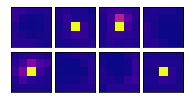

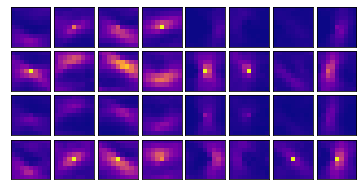

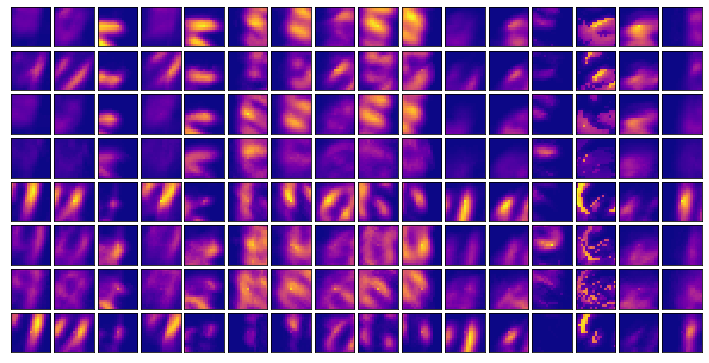

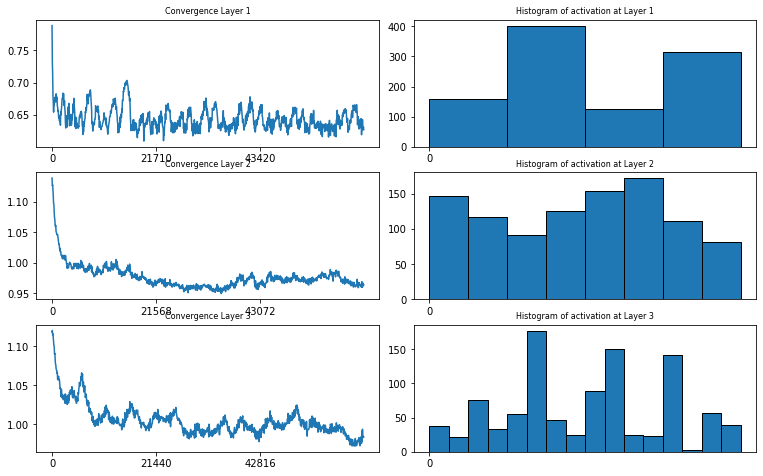

In [3]:
#timestr = time.strftime("%Y%m%d")
hom = False
homrun = False
timestr = '20201021'
if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
print(fname)

L1 = ClusteringLayer(tau=tau,R=R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L2 = ClusteringLayer(tau=10 * tau,R=2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L3 = ClusteringLayer(tau=10 * 10 * tau,R=2 * 2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
Net = Network([L1, L2, L3])

if not os.path.isfile(fname):
    ClusterLayer, event_output = Net.TrainCluster(
            event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
        )
    SaveObject(ClusterLayer, fname)
else: 
    ClusterLayer, Classif0 = LoadObject(fname)
    
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

### Classification performance without homeostasis

In [4]:
homrun = False
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:60.0% ### normalized:60.0% ### euclidian:50.0% ### 


### Homeostasis rule used for classification only, after training the network

In [5]:
homrun = True
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:50.0% ### normalized:42.5% ### euclidian:42.5% ### 


## 1.a. Use of the following homeostasis gain

Gain function to select the closest prototype:
$$ \gamma_k = e^{(f_k-\frac{1}{nb_{proto}})}$$
where $f_k = \frac{\text{number of activation of prototype k}}{\text{total number of events}}$

Records/EXP_03_NMNIST/20201028_x1__hots_0.9ms_lagorce_homeo.pkl
layer number:0 - homeo_power=0.032
layer number:1 - homeo_power=0.019
layer number:2 - homeo_power=0.018


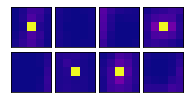

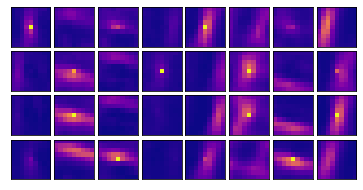

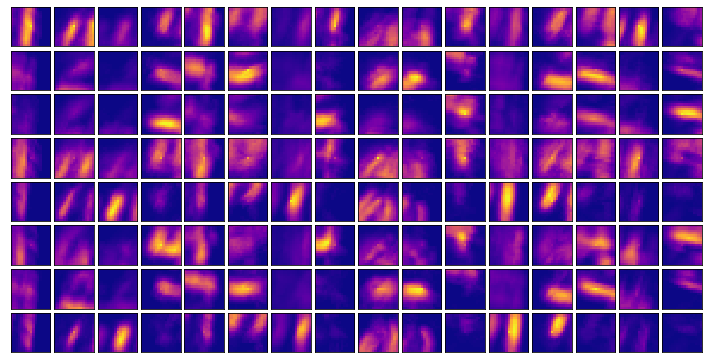

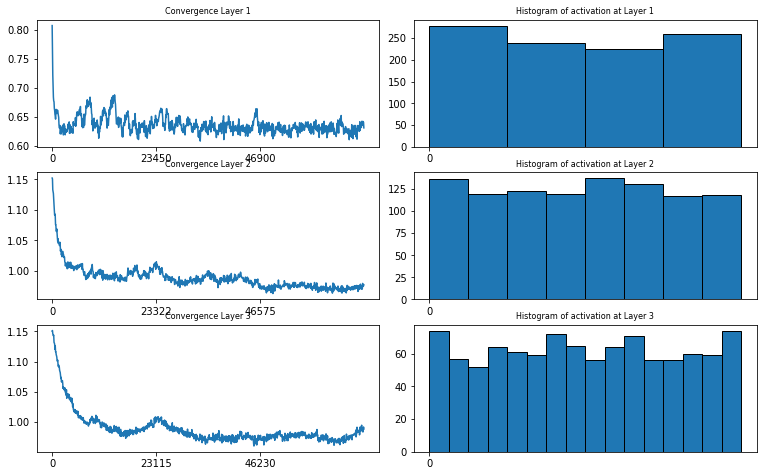

In [6]:
#timestr = time.strftime("%Y%m%d")
hom=True
homrun=True
timestr = '20201028_x1_'
if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
print(fname)

L1 = ClusteringLayer(tau=tau,R=R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L2 = ClusteringLayer(tau=10 * tau,R=2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L3 = ClusteringLayer(tau=10 * 10 * tau,R=2 * 2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
Net = Network([L1, L2, L3])

if not os.path.isfile(fname):
    ClusterLayer, event_output = Net.TrainCluster(
            event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
        )
    SaveObject(ClusterLayer, fname)
else: 
    ClusterLayer = LoadObject(fname)
    
for i in range(3):
    print('layer number:'+str(i)+' - homeo_power='+str(np.round(ClusterLayer[i].hompower,3)))
    
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

In [7]:
homrun = False
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:52.5% ### normalized:47.5% ### euclidian:45.0% ### 


In [8]:
homrun = True
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:57.49999999999999% ### normalized:55.00000000000001% ### euclidian:50.0% ### 


[]


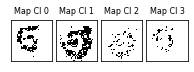

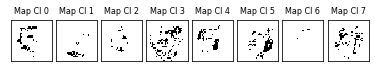

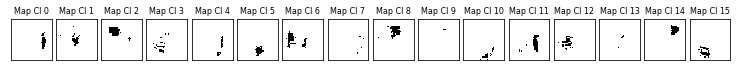

In [9]:
event_to_show, eventnul, eventnull, label_to_show, labelnull = LoadNMNIST(
1, 0, 0, Path=DataPath, OutOnePolarity=False, ListPolarities=None, verbose=0)
Net.RunNetwork(event_to_show, NbClusterList=ClusterLayer, homrun=homrun)
mapL1 = GenerateActivationMap(Net.Layers[0].output, ClusterLayer[0])
DisplayActivationMap(mapL1, scale=2)
mapL2 = GenerateActivationMap(Net.Layers[1].output, ClusterLayer[1])
DisplayActivationMap(mapL2, scale=2)
mapL3 = GenerateActivationMap(Net.Layers[2].output, ClusterLayer[2])
DisplayActivationMap(mapL3, scale=2)

## 1.b.
$$ \gamma_k = e^{2(f_k-\frac{1}{nb_{proto}})}$$

Records/EXP_03_NMNIST/20201028_x2__hots_0.9ms_lagorce_homeo.pkl
layer number:0 - homeo_power=0.037
layer number:1 - homeo_power=0.018
layer number:2 - homeo_power=0.02


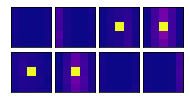

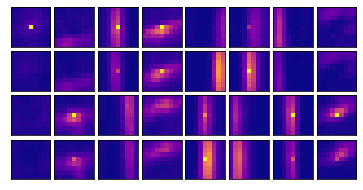

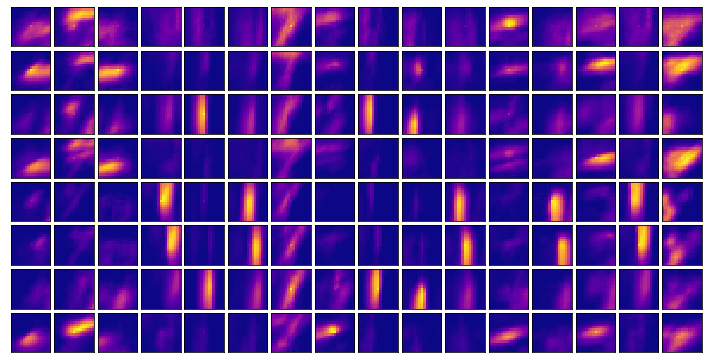

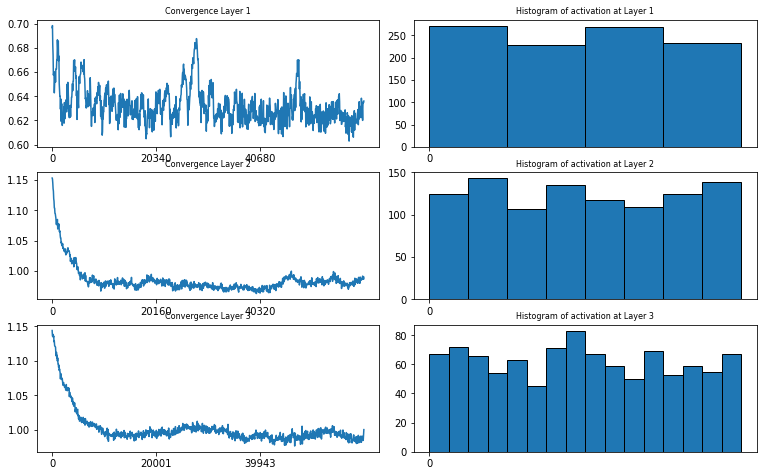

In [10]:
#timestr = time.strftime("%Y%m%d")
hom=True
homrun=True
timestr = '20201028_x2_'
if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
print(fname)

L1 = ClusteringLayer(tau=tau,R=R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L2 = ClusteringLayer(tau=10 * tau,R=2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L3 = ClusteringLayer(tau=10 * 10 * tau,R=2 * 2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
Net = Network([L1, L2, L3])

if not os.path.isfile(fname):
    ClusterLayer, event_output = Net.TrainCluster(
            event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
        )
    SaveObject(ClusterLayer, fname)
else: 
    ClusterLayer = LoadObject(fname)
    
for i in range(3):
    print('layer number:'+str(i)+' - homeo_power='+str(np.round(ClusterLayer[i].hompower,3)))
    
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

In [11]:
homrun = False
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:40.0% ### normalized:35.0% ### euclidian:40.0% ### 


In [12]:
homrun = True
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:35.0% ### normalized:40.0% ### euclidian:32.5% ### 


## 2.a. 
$$ \gamma_k = e^{R(f_k-\frac{1}{nb_{proto}})}$$

Records/EXP_03_NMNIST/20201028_xR__hots_0.9ms_lagorce_homeo.pkl
layer number:0 - homeo_power=0.025
layer number:1 - homeo_power=0.02
layer number:2 - homeo_power=0.023


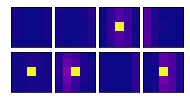

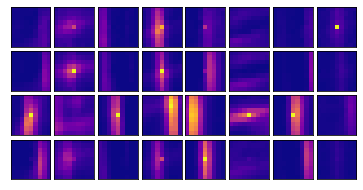

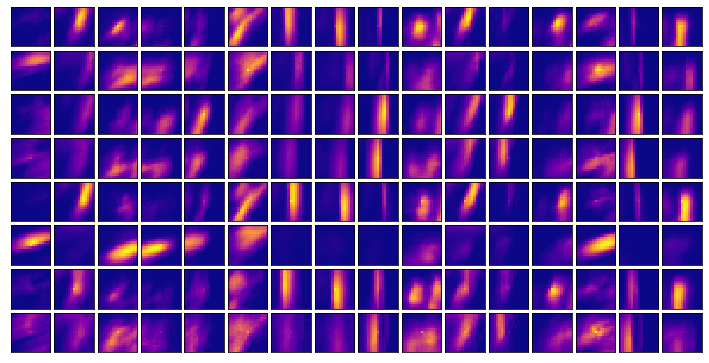

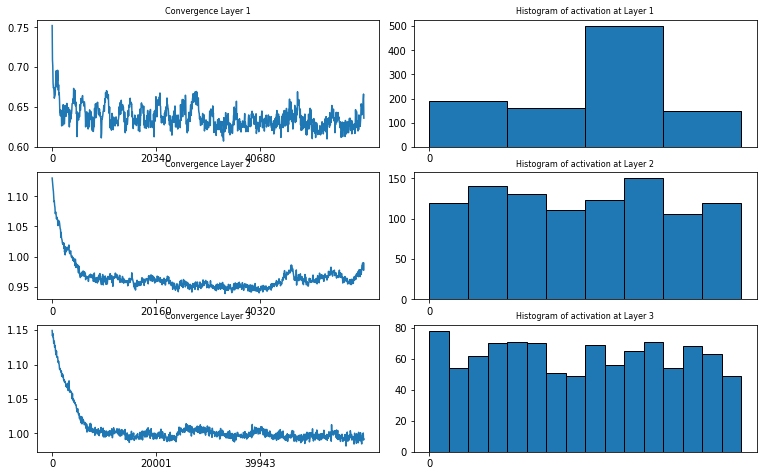

In [13]:
#timestr = time.strftime("%Y%m%d")
hom=True
homrun=True
timestr = '20201028_xR_'
if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
print(fname)

L1 = ClusteringLayer(tau=tau,R=R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L2 = ClusteringLayer(tau=10 * tau,R=2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L3 = ClusteringLayer(tau=10 * 10 * tau,R=2 * 2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
Net = Network([L1, L2, L3])

if not os.path.isfile(fname):
    ClusterLayer, event_output = Net.TrainCluster(
            event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
        )
    SaveObject(ClusterLayer, fname)
else: 
    ClusterLayer = LoadObject(fname)
    
for i in range(3):
    print('layer number:'+str(i)+' - homeo_power='+str(np.round(ClusterLayer[i].hompower,3)))
    
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

In [14]:
homrun = False
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:52.5% ### normalized:52.5% ### euclidian:47.5% ### 


In [15]:
homrun = True
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:37.5% ### normalized:35.0% ### euclidian:32.5% ### 


## 2.b.
$$ \gamma_k = e^{2R(f_k-\frac{1}{nb_{proto}})}$$

Records/EXP_03_NMNIST/20201028_x2R__hots_0.9ms_lagorce_homeo.pkl
layer number:0 - homeo_power=0.033
layer number:1 - homeo_power=0.02
layer number:2 - homeo_power=0.019


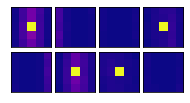

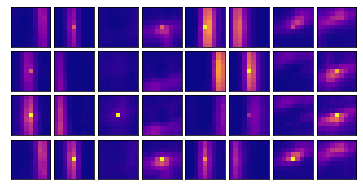

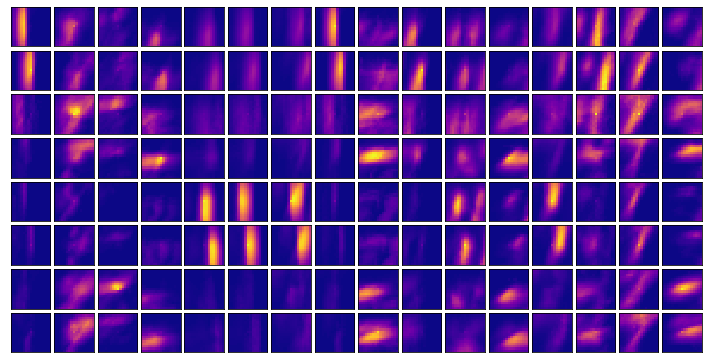

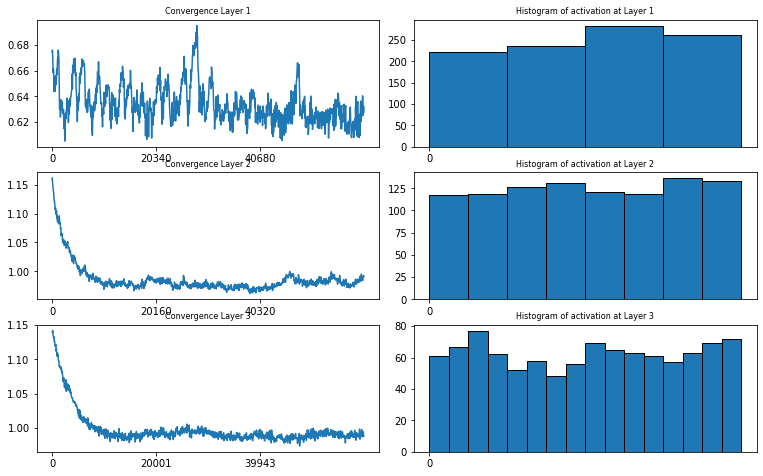

In [16]:
#timestr = time.strftime("%Y%m%d")
hom=True
homrun=True
timestr = '20201028_x2R_'
if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
print(fname)

L1 = ClusteringLayer(tau=tau,R=R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L2 = ClusteringLayer(tau=10 * tau,R=2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L3 = ClusteringLayer(tau=10 * 10 * tau,R=2 * 2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
Net = Network([L1, L2, L3])

if not os.path.isfile(fname):
    ClusterLayer, event_output = Net.TrainCluster(
            event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
        )
    SaveObject(ClusterLayer, fname)
else: 
    ClusterLayer = LoadObject(fname)
    
for i in range(3):
    print('layer number:'+str(i)+' - homeo_power='+str(np.round(ClusterLayer[i].hompower,3)))
    
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

In [17]:
homrun = False
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:42.5% ### normalized:40.0% ### euclidian:37.5% ### 


In [18]:
homrun = True
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:37.5% ### normalized:32.5% ### euclidian:27.500000000000004% ### 


## 3.
$$ \gamma_k = Re^{f_k-\frac{1}{nb_{proto}}}$$

Records/EXP_03_NMNIST/20201028_Rxe__hots_0.9ms_lagorce_homeo.pkl
layer number:0 - homeo_power=0.025
layer number:1 - homeo_power=0.023
layer number:2 - homeo_power=0.02


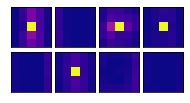

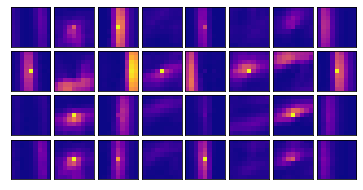

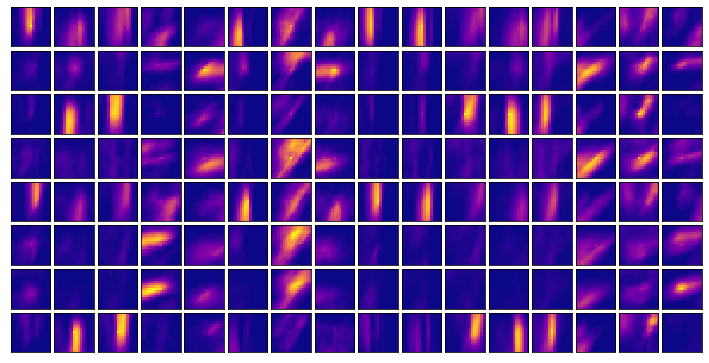

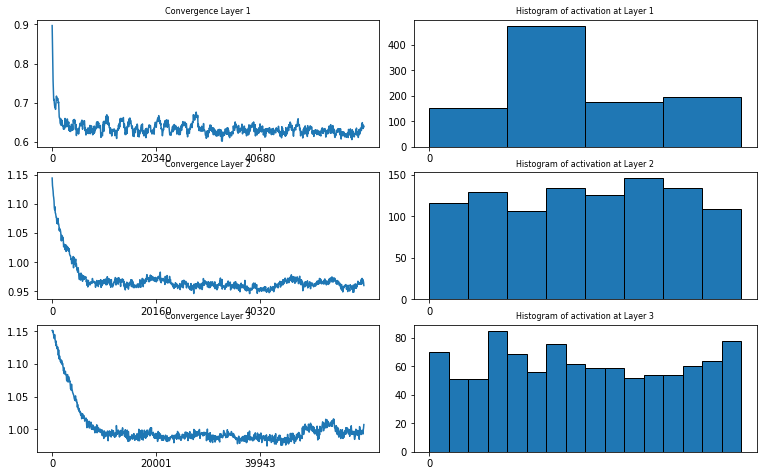

In [19]:
#timestr = time.strftime("%Y%m%d")
hom=True
homrun=True
timestr = '20201028_Rxe_'
if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
print(fname)

L1 = ClusteringLayer(tau=tau,R=R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L2 = ClusteringLayer(tau=10 * tau,R=2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L3 = ClusteringLayer(tau=10 * 10 * tau,R=2 * 2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
Net = Network([L1, L2, L3])

if not os.path.isfile(fname):
    ClusterLayer, event_output = Net.TrainCluster(
            event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
        )
    SaveObject(ClusterLayer, fname)
else: 
    ClusterLayer = LoadObject(fname)
    
for i in range(3):
    print('layer number:'+str(i)+' - homeo_power='+str(np.round(ClusterLayer[i].hompower,3)))
    
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

In [20]:
homrun = False
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:40.0% ### normalized:37.5% ### euclidian:42.5% ### 


In [21]:
homrun = True
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:35.0% ### normalized:30.0% ### euclidian:22.5% ### 


## 4.
$$ \gamma_k = e^{nb_{proto}(f_k-\frac{1}{nb_{proto}})}$$

Records/EXP_03_NMNIST/20201028_xN__hots_0.9ms_lagorce_homeo.pkl
layer number:0 - homeo_power=0.037
layer number:1 - homeo_power=0.02
layer number:2 - homeo_power=0.018


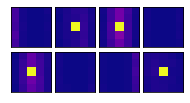

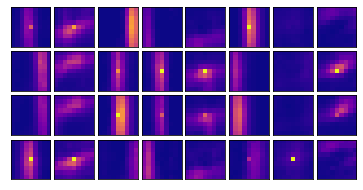

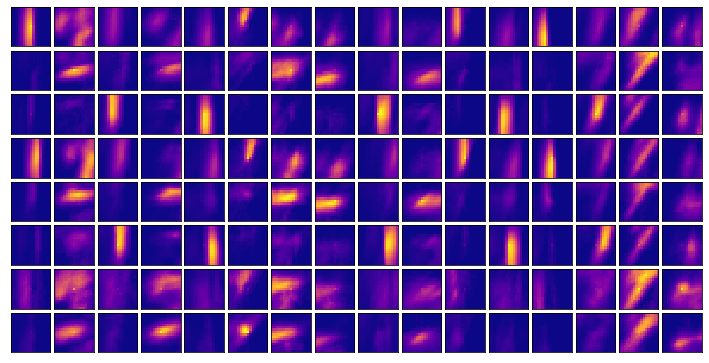

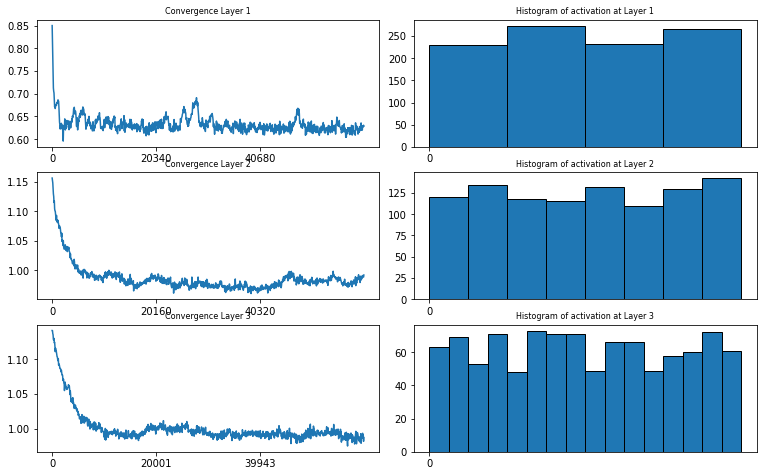

In [22]:
#timestr = time.strftime("%Y%m%d")
hom=True
homrun=True
timestr = '20201028_xN_'
if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
print(fname)

L1 = ClusteringLayer(tau=tau,R=R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L2 = ClusteringLayer(tau=10 * tau,R=2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L3 = ClusteringLayer(tau=10 * 10 * tau,R=2 * 2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
Net = Network([L1, L2, L3])

if not os.path.isfile(fname):
    ClusterLayer, event_output = Net.TrainCluster(
            event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
        )
    SaveObject(ClusterLayer, fname)
else: 
    ClusterLayer = LoadObject(fname)
    
for i in range(3):
    print('layer number:'+str(i)+' - homeo_power='+str(np.round(ClusterLayer[i].hompower,3)))
    
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

In [23]:
homrun = False
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:45.0% ### normalized:40.0% ### euclidian:35.0% ### 


In [24]:
homrun = True
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:20.0% ### normalized:20.0% ### euclidian:20.0% ### 


## 5. 
$$ \gamma_k = e^{\frac{1}{nb_{proto}}(f_k-\frac{1}{nb_{proto}})}$$

Records/EXP_03_NMNIST/20201028_surR__hots_0.9ms_lagorce_homeo.pkl
layer number:0 - homeo_power=0.026
layer number:1 - homeo_power=0.02
layer number:2 - homeo_power=0.017


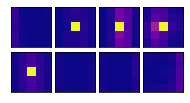

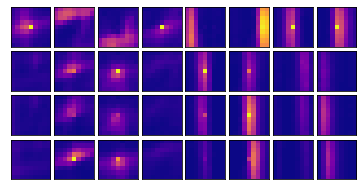

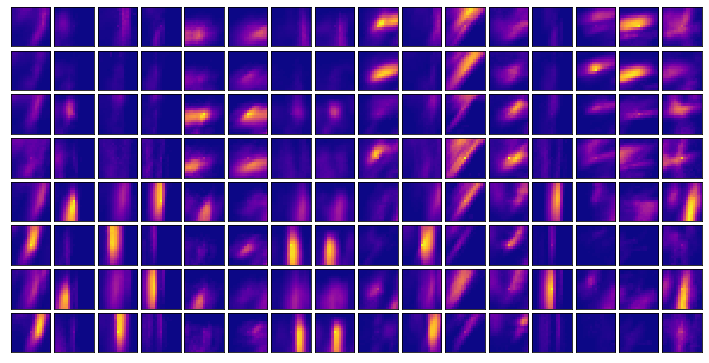

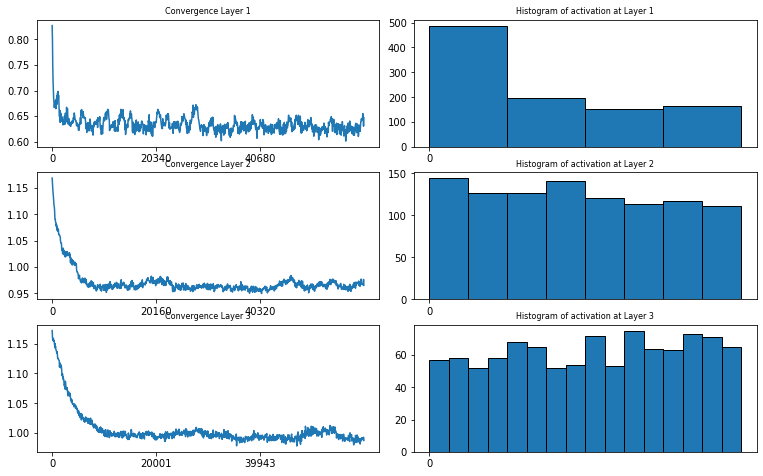

In [25]:
#timestr = time.strftime("%Y%m%d")
hom=True
homrun=True
timestr = '20201028_surR_'
if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
print(fname)

L1 = ClusteringLayer(tau=tau,R=R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L2 = ClusteringLayer(tau=10 * tau,R=2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L3 = ClusteringLayer(tau=10 * 10 * tau,R=2 * 2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
Net = Network([L1, L2, L3])

if not os.path.isfile(fname):
    ClusterLayer, event_output = Net.TrainCluster(
            event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
        )
    SaveObject(ClusterLayer, fname)
else: 
    ClusterLayer = LoadObject(fname)
    
for i in range(3):
    print('layer number:'+str(i)+' - homeo_power='+str(np.round(ClusterLayer[i].hompower,3)))
    
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

In [26]:
homrun = False
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:45.0% ### normalized:42.5% ### euclidian:42.5% ### 


In [27]:
homrun = True
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
battacha:32.5% ### normalized:32.5% ### euclidian:30.0% ### 


## 6.a. setting gain between 0.8 and 1.2
$$ \gamma_k = e^{\frac{af_k+b}{c-f_k}}$$

Records/EXP_03_NMNIST/20201028_[0.8,1.2]__hots_0.9ms_lagorce_homeo.pkl
layer number:0 - homeo_power=0.04
layer number:1 - homeo_power=0.021
layer number:2 - homeo_power=0.021


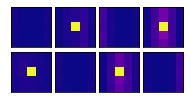

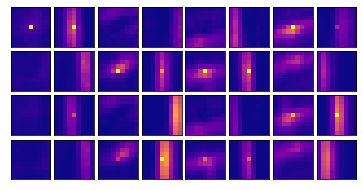

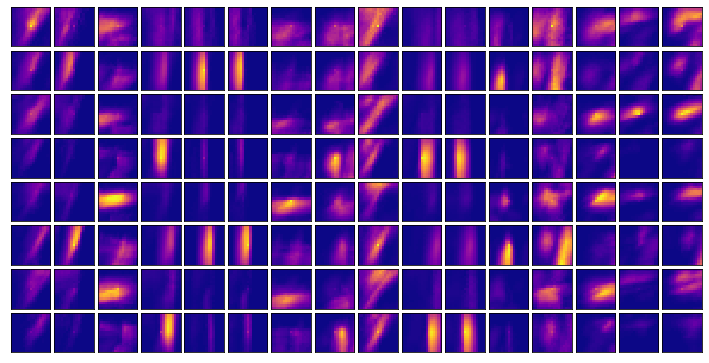

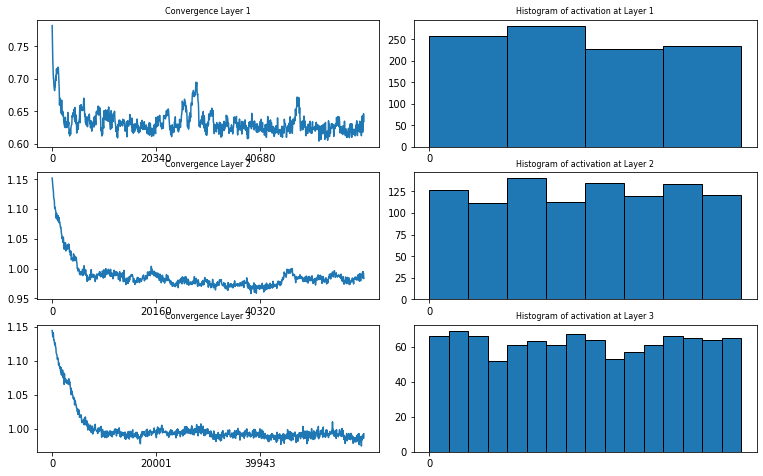

In [28]:
#timestr = time.strftime("%Y%m%d")
hom=True
homrun=True
timestr = '20201028_[0.8,1.2]_'
if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
print(fname)

L1 = ClusteringLayer(tau=tau,R=R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L2 = ClusteringLayer(tau=10 * tau,R=2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L3 = ClusteringLayer(tau=10 * 10 * tau,R=2 * 2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
Net = Network([L1, L2, L3])

if not os.path.isfile(fname):
    ClusterLayer, event_output = Net.TrainCluster(
            event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
        )
    SaveObject(ClusterLayer, fname)
else: 
    ClusterLayer = LoadObject(fname)
    
for i in range(3):
    print('layer number:'+str(i)+' - homeo_power='+str(np.round(ClusterLayer[i].hompower,3)))
    
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

In [29]:
homrun = False
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:47.5% ### normalized:47.5% ### euclidian:45.0% ### 


In [30]:
homrun = True
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:37.5% ### normalized:32.5% ### euclidian:32.5% ### 


## 6.b. setting gain between 0.6 and 1.4
$$ \gamma_k = e^{\frac{af_k+b}{c-f_k}}$$

Records/EXP_03_NMNIST/20201028_[0.6,1.4]__hots_0.9ms_lagorce_homeo.pkl
layer number:0 - homeo_power=0.037
layer number:1 - homeo_power=0.019
layer number:2 - homeo_power=0.018


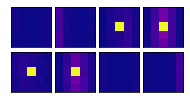

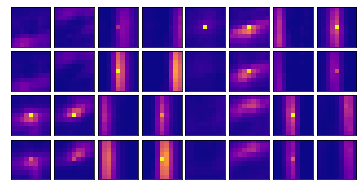

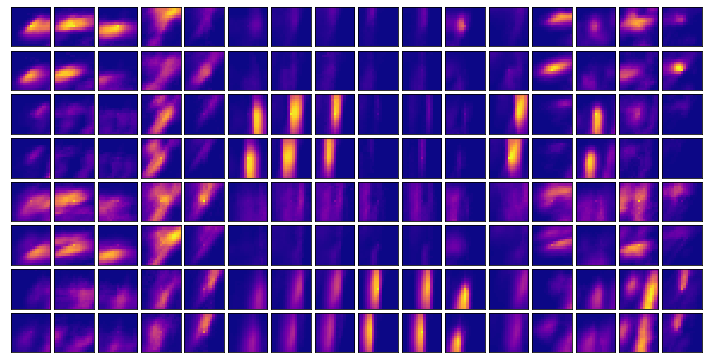

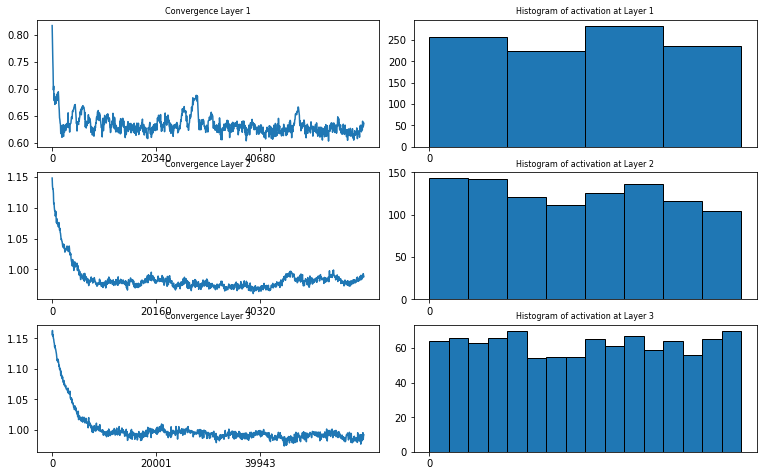

In [31]:
#timestr = time.strftime("%Y%m%d")
hom=True
homrun=True
timestr = '20201028_[0.6,1.4]_'
if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
print(fname)

L1 = ClusteringLayer(tau=tau,R=R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L2 = ClusteringLayer(tau=10 * tau,R=2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L3 = ClusteringLayer(tau=10 * 10 * tau,R=2 * 2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
Net = Network([L1, L2, L3])

if not os.path.isfile(fname):
    ClusterLayer, event_output = Net.TrainCluster(
            event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
        )
    SaveObject(ClusterLayer, fname)
else: 
    ClusterLayer = LoadObject(fname)
    
for i in range(3):
    print('layer number:'+str(i)+' - homeo_power='+str(np.round(ClusterLayer[i].hompower,3)))
    
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

In [32]:
homrun = False
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)
Classif0 = Classifier(event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te)
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:47.5% ### normalized:42.5% ### euclidian:40.0% ### 


In [33]:
homrun = True
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)
Classif0 = Classifier(event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te)
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:25.0% ### normalized:27.500000000000004% ### euclidian:25.0% ### 


## 6.c. setting gain between 0.7 and 1.3
$$ \gamma_k = e^{\frac{af_k+b}{c-f_k}}$$

Records/EXP_03_NMNIST/20201028_[0.7,1.3]__hots_0.9ms_lagorce_homeo.pkl
layer number:0 - homeo_power=0.025
layer number:1 - homeo_power=0.02
layer number:2 - homeo_power=0.02


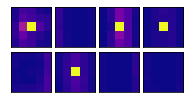

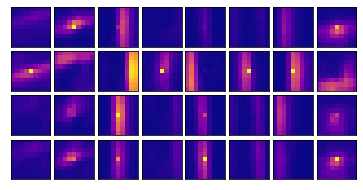

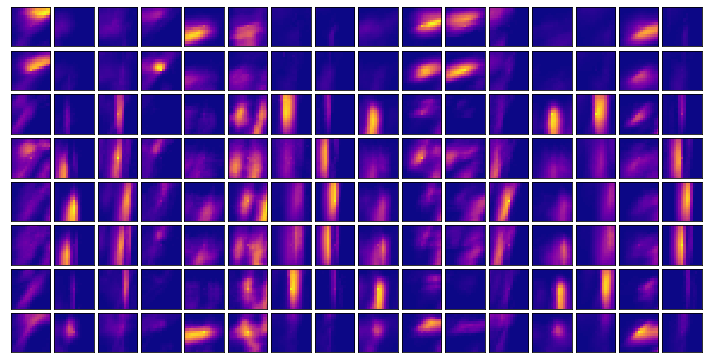

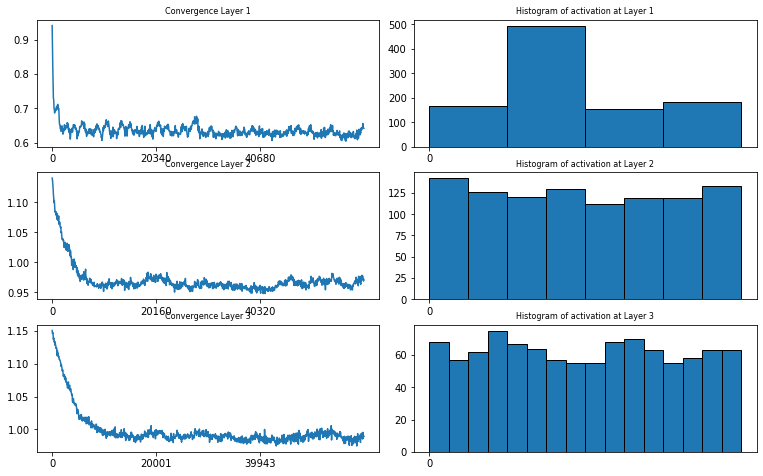

In [34]:
#timestr = time.strftime("%Y%m%d")
hom=True
homrun=True
timestr = '20201028_[0.7,1.3]_'
if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
print(fname)

L1 = ClusteringLayer(tau=tau,R=R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L2 = ClusteringLayer(tau=10 * tau,R=2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L3 = ClusteringLayer(tau=10 * 10 * tau,R=2 * 2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
Net = Network([L1, L2, L3])

if not os.path.isfile(fname):
    ClusterLayer, event_output = Net.TrainCluster(
            event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
        )
    SaveObject(ClusterLayer, fname)
else: 
    ClusterLayer = LoadObject(fname)
    
for i in range(3):
    print('layer number:'+str(i)+' - homeo_power='+str(np.round(ClusterLayer[i].hompower,3)))
    
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

In [35]:
homrun = False
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)
Classif0 = Classifier(event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te)
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)
homrun = True
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)
Classif0 = Classifier(event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te)
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:42.5% ### normalized:40.0% ### euclidian:37.5% ### 
battacha:35.0% ### normalized:37.5% ### euclidian:32.5% ### 


## 7.a.
$$ \gamma_k = e^{\frac{nb_{proto}}{2}(f_k-\frac{1}{nb_{proto}})}$$

Records/EXP_03_NMNIST/20201028_xNsur2__hots_0.9ms_lagorce_homeo.pkl
layer number:0 - homeo_power=0.028
layer number:1 - homeo_power=0.022
layer number:2 - homeo_power=0.017


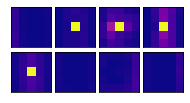

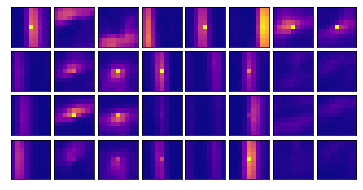

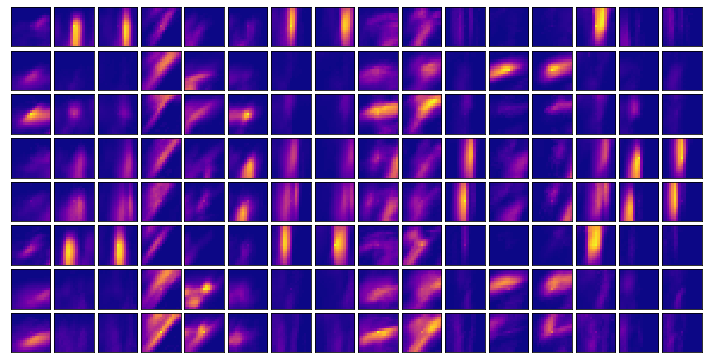

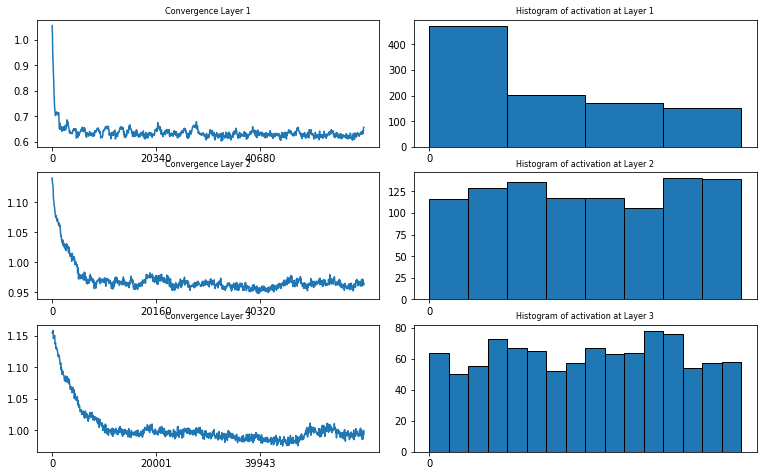

In [36]:
#timestr = time.strftime("%Y%m%d")
hom=True
homrun=True
timestr = '20201028_xNsur2_'
if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
print(fname)

L1 = ClusteringLayer(tau=tau,R=R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L2 = ClusteringLayer(tau=10 * tau,R=2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L3 = ClusteringLayer(tau=10 * 10 * tau,R=2 * 2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
Net = Network([L1, L2, L3])

if not os.path.isfile(fname):
    ClusterLayer, event_output = Net.TrainCluster(
            event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
        )
    SaveObject(ClusterLayer, fname)
else: 
    ClusterLayer = LoadObject(fname)
    
for i in range(3):
    print('layer number:'+str(i)+' - homeo_power='+str(np.round(ClusterLayer[i].hompower,3)))
    
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

In [37]:
homrun = False
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:45.0% ### normalized:40.0% ### euclidian:37.5% ### 


In [38]:
homrun = True
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:27.500000000000004% ### normalized:30.0% ### euclidian:20.0% ### 


## 7.b. 
$$ \gamma_k = e^{\frac{nb_{proto}}{8}(f_k-\frac{1}{nb_{proto}})}$$

Records/EXP_03_NMNIST/20201028_xNsur8__hots_0.9ms_lagorce_homeo.pkl
layer number:0 - homeo_power=0.027
layer number:1 - homeo_power=0.022
layer number:2 - homeo_power=0.018


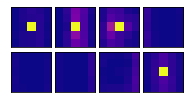

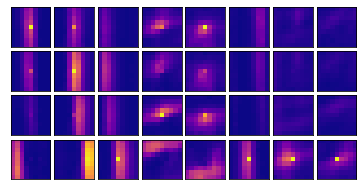

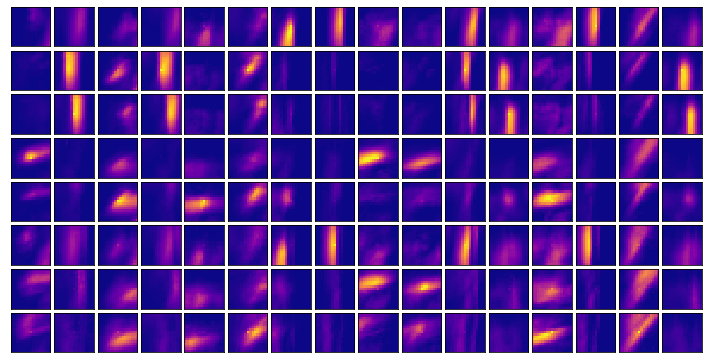

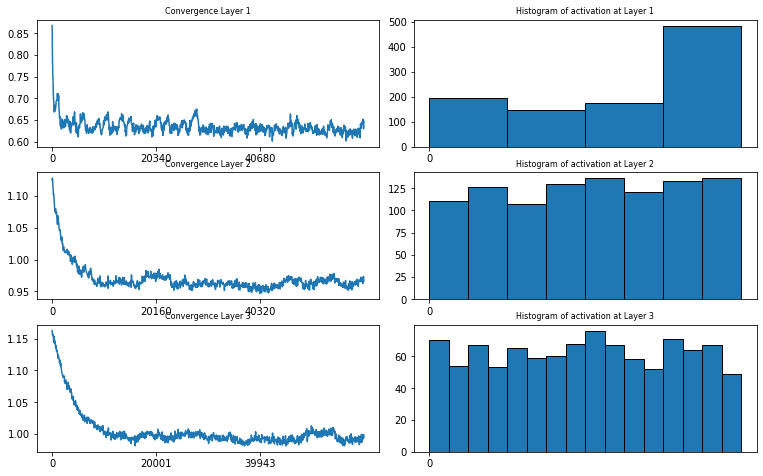

In [39]:
#timestr = time.strftime("%Y%m%d")
hom=True
homrun=True
timestr = '20201028_xNsur8_'
if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
print(fname)

L1 = ClusteringLayer(tau=tau,R=R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L2 = ClusteringLayer(tau=10 * tau,R=2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L3 = ClusteringLayer(tau=10 * 10 * tau,R=2 * 2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
Net = Network([L1, L2, L3])

if not os.path.isfile(fname):
    ClusterLayer, event_output = Net.TrainCluster(
            event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
        )
    SaveObject(ClusterLayer, fname)
else: 
    ClusterLayer = LoadObject(fname)
    
for i in range(3):
    print('layer number:'+str(i)+' - homeo_power='+str(np.round(ClusterLayer[i].hompower,3)))
    
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

In [40]:
homrun = False
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:45.0% ### normalized:35.0% ### euclidian:37.5% ### 


In [41]:
homrun = True
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:22.5% ### normalized:25.0% ### euclidian:22.5% ### 


## 7.c.
$$ \gamma_k = e^{\frac{nb_{proto}}{4}(f_k-\frac{1}{nb_{proto}})}$$

Records/EXP_03_NMNIST/20201028_xNsur4__hots_0.9ms_lagorce_homeo.pkl
layer number:0 - homeo_power=0.035
layer number:1 - homeo_power=0.021
layer number:2 - homeo_power=0.02


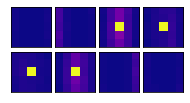

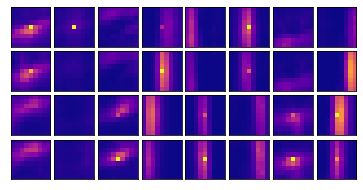

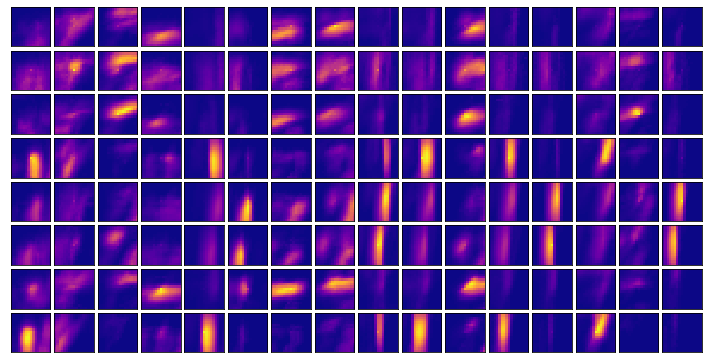

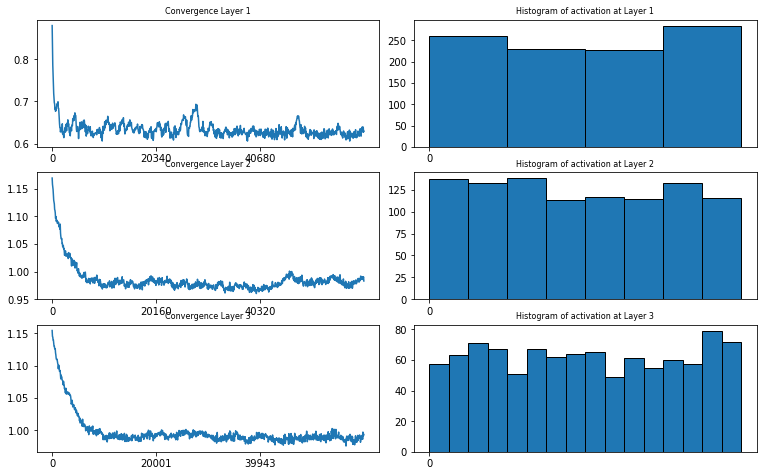

In [42]:
#timestr = time.strftime("%Y%m%d")
hom=True
homrun=True
timestr = '20201028_xNsur4_'
if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
print(fname)

L1 = ClusteringLayer(tau=tau,R=R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L2 = ClusteringLayer(tau=10 * tau,R=2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L3 = ClusteringLayer(tau=10 * 10 * tau,R=2 * 2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
Net = Network([L1, L2, L3])

if not os.path.isfile(fname):
    ClusterLayer, event_output = Net.TrainCluster(
            event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
        )
    SaveObject(ClusterLayer, fname)
else: 
    ClusterLayer = LoadObject(fname)
    
for i in range(3):
    print('layer number:'+str(i)+' - homeo_power='+str(np.round(ClusterLayer[i].hompower,3)))
    
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

In [43]:
homrun = False
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:40.0% ### normalized:42.5% ### euclidian:45.0% ### 


In [44]:
homrun = True
event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

battacha:30.0% ### normalized:32.5% ### euclidian:40.0% ### 
